In [1]:
import os
import json
import numpy as np
import heapq
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

In [35]:
# (A) 그래프 생성
def create_bus_graph(stop_csv_path, line_stop_csv_path):
    """
    1) stop_csv_path 에서 정류장 정보 읽어 노드 생성
       - 노드는 정류장ID를 키로, 속성: station_name, x, y
    2) line_stop_csv_path 에서 노선별 정류장 순서를 읽어,
       순방향 + 역방향(왕복) 엣지를 추가.
       - 엣지 속성으로 route_name, route_number, weight 등을 저장
    3) A* 데모를 위해:
       - stations: 정류장ID 리스트
       - edges: [(u, v, w, route_name), ...] 형태로 모두 수집
       - heuristic_table: 임시로 (정류장ID -> 랜덤값) 혹은 0 으로 설정
    4) return: G, stations, edges, heuristic_table
    """

    stop_df = pd.read_csv(stop_csv_path, encoding='cp949')
    line_stop_df = pd.read_csv(line_stop_csv_path, encoding='cp949')

    G = nx.DiGraph()
    station_name_to_id = {}

    # (1) 노드 생성
    for i, row in stop_df.iterrows():
        station_id = row['정류장ID']
        station_name = row['버스정류장명']
        x_coord = row['정류장 X좌표']
        y_coord = row['정류장 Y좌표']

        G.add_node(
            station_id,
            station_name=station_name,
            x=x_coord,
            y=y_coord
        )
        # 매핑 사전 저장 (정류장명 -> 정류장ID)
        station_name_to_id[station_name] = station_id

    # (2) 엣지 생성 (왕복 처리)
    edges = []
    for route_number, route_group in line_stop_df.groupby('노선번호'):
        route_group_sorted = route_group.sort_values('정류장순서')
        route_name = route_group_sorted.iloc[0]['노선번호']

        for i in range(len(route_group_sorted) - 1):
            from_stop = route_group_sorted.iloc[i]['정류장ID']
            to_stop   = route_group_sorted.iloc[i + 1]['정류장ID']
            
            # 순방향
            G.add_edge(
                int(from_stop), int(to_stop),
                route_number=route_number,
                route_name=route_name,
                weight=int(np.random.randint(1,100))  # 실제론 거리 or 시간
            )
            edges.append((from_stop, to_stop, 1, route_name))

            # 역방향(왕복)
            G.add_edge(
                int(to_stop), int(from_stop),
                route_number=route_number,
                route_name=route_name,
                weight=int(np.random.randint(1,100))
            )
            edges.append((to_stop, from_stop, 1, route_name))

    # (3) stations 리스트
    stations = list(G.nodes())

    # (4) 휴리스틱 테이블 (A*용)
    heuristic_table = {station: np.random.randint(0, 10) for station in stations}

    return G, stations, edges, heuristic_table

In [25]:
G.edges

OutEdgeView([(6800001, 6801982), (6800001, 6805516), (6800001, 6800157), (6800001, 6800002), (6800001, 6801485), (6800001, 6800076), (6800001, 6801141), (6800001, 6800045), (6800002, 6800001), (6800002, 6801800), (6800002, 6800748), (6800004, 6800748), (6800004, 6800005), (6800005, 6800004), (6800005, 6800136), (6800005, 6801982), (6800005, 6801181), (6800006, 6800165), (6800006, 6805261), (6800006, 6800136), (6800006, 6800007), (6800007, 6800006), (6800007, 6801144), (6800007, 6801047), (6800007, 6800137), (6800008, 6800038), (6800008, 6806370), (6800008, 6800040), (6800009, 6801144), (6800009, 6800010), (6800010, 6800009), (6800010, 6801256), (6800010, 6800148), (6800010, 6800011), (6800011, 6801256), (6800011, 6801231), (6800011, 6800010), (6800011, 6801805), (6800013, 6802316), (6800013, 6800014), (6800014, 6800013), (6800014, 6800587), (6800014, 6800605), (6800014, 6800015), (6800015, 6800014), (6800015, 6800949), (6800016, 6801817), (6800016, 6801874), (6800016, 6801873), (680001

In [36]:
####################################
# (B) 시각화 함수
####################################
def plot_bus_graph(G, path=None, start=None, goal=None,
                   checking_edges=None, weight_tag=True,
                   route_tag=False, node_size=50,
                   title="Bus Routes Graph"):
    """
    - path: A* 결과 (정류장ID list)
    - start, goal: 노드(정류장ID)
    - checking_edges: 탐색 중 확인한 엣지
    - weight_tag: True면 edge weight 표시
    - route_tag: True면 edge에 노선명(route_name) 표시
    - node_size: 노드 크기 
    """

    # (1) 노드 위치를 (x, y) 좌표로 지정
    pos = {}
    for n in G.nodes():
        x_coord = G.nodes[n].get('x', 0.0)
        y_coord = G.nodes[n].get('y', 0.0)
        pos[n] = (x_coord, y_coord)

    # (2) 그림 크기, 축 등
    plt.figure(figsize=(20, 16))

    # (3) 전체 엣지
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        alpha=0.5,
        arrows=True,
        connectionstyle='arc3,rad=0.05'
    )

    # (4) path 강조
    if path:
        path_edges = list(zip(path, path[1:]))

        # 탐색 중 확인한 엣지 (주황색)
        if checking_edges:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=checking_edges,
                edge_color='orange',
                alpha=0.4,
                width=3,
                arrows=True,
                connectionstyle='arc3,rad=0.05'
            )
        # 최종 경로 (빨간색)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='red',
            width=5,
            arrows=True,
            connectionstyle='arc3,rad=0.05'
        )

    # (5) 노드 표시
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color='lightblue'
    )

    # (6) 엣지 라벨
    if weight_tag:
        edge_labels = {
            (u, v): G[u][v].get('weight', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='green'
        )
    elif route_tag:
        edge_labels = {
            (u, v): G[u][v].get('route_name', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='blue'
        )


    if path and start and goal:
        title = f"{title}\nStart: {start}, Goal: {goal}"

    plt.title(title, fontsize=13)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [44]:
stop_csv_path = "data/세종특별자치시_정류장정보_20241125.csv"       # 예: "정류장ID, 버스정류장명, 정류장 X좌표, 정류장 Y좌표" 등 포함
line_stop_csv_path = "data/세종특별자치시_노선별_정류장현황_20241125.csv"  # 예: "노선번호, 노선명, 정류장ID, 정류장순서" 등 포함

# 그래프 생성
G, stations, edges, heuristic_table = create_bus_graph(
    stop_csv_path,
    line_stop_csv_path
)

In [45]:
graph_json = json_graph.node_link_data(G)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [46]:
#save graph as json
graph_json = json_graph.node_link_data(G)
with open("graphs/sejong_bus.json", "w") as json_file:
    json.dump(graph_json, json_file)

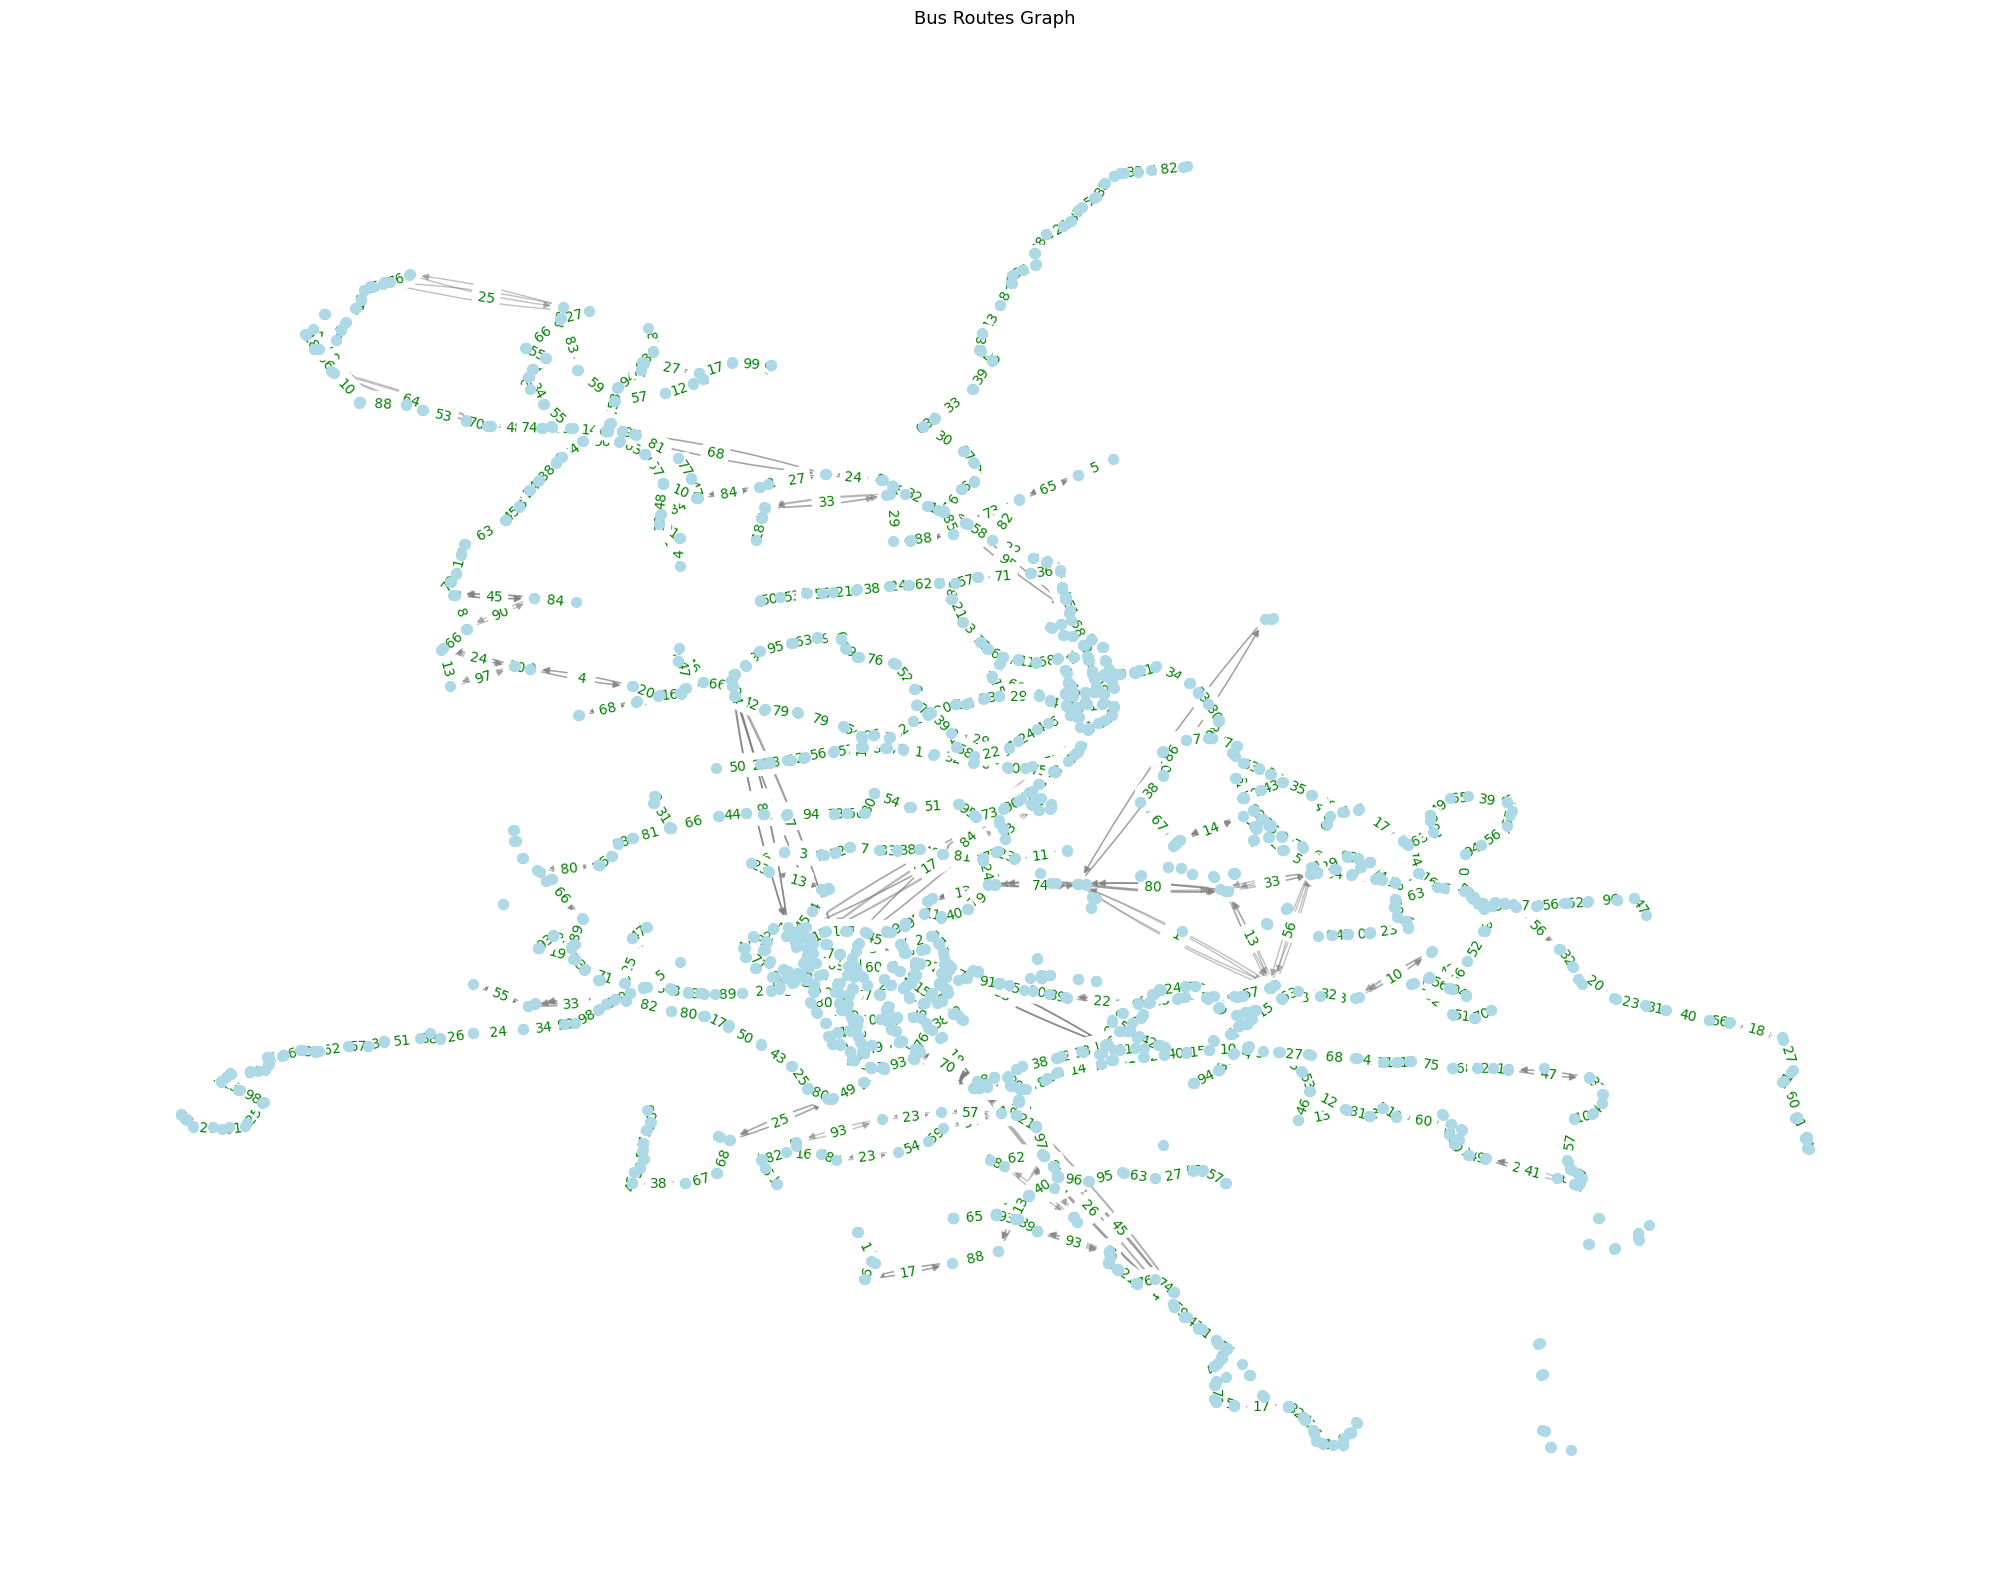

In [47]:
plot_bus_graph(G)

In [48]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


In [49]:
# A* 시연
if len(stations) >= 2:
    start = stations[30]            
    goal = stations[100]           
    path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)

    print("Count       :", count)
    print("Cost        :", cost)
    print("# of Checking edges:", len(checking_edges))
    print("Path        :", path)
else:
    start, goal, path, cost, count, checking_edges = None, None, None, None, None, None

Count       : 2733
Cost        : 583
# of Checking edges: 1242
Path        : [6800031, 6802361, 6802359, 6801162, 6801842, 6805814, 6806337, 6806335, 6802389, 6802391, 6802393, 6800324, 6800316, 6800974, 6806239, 6800315, 6800109]


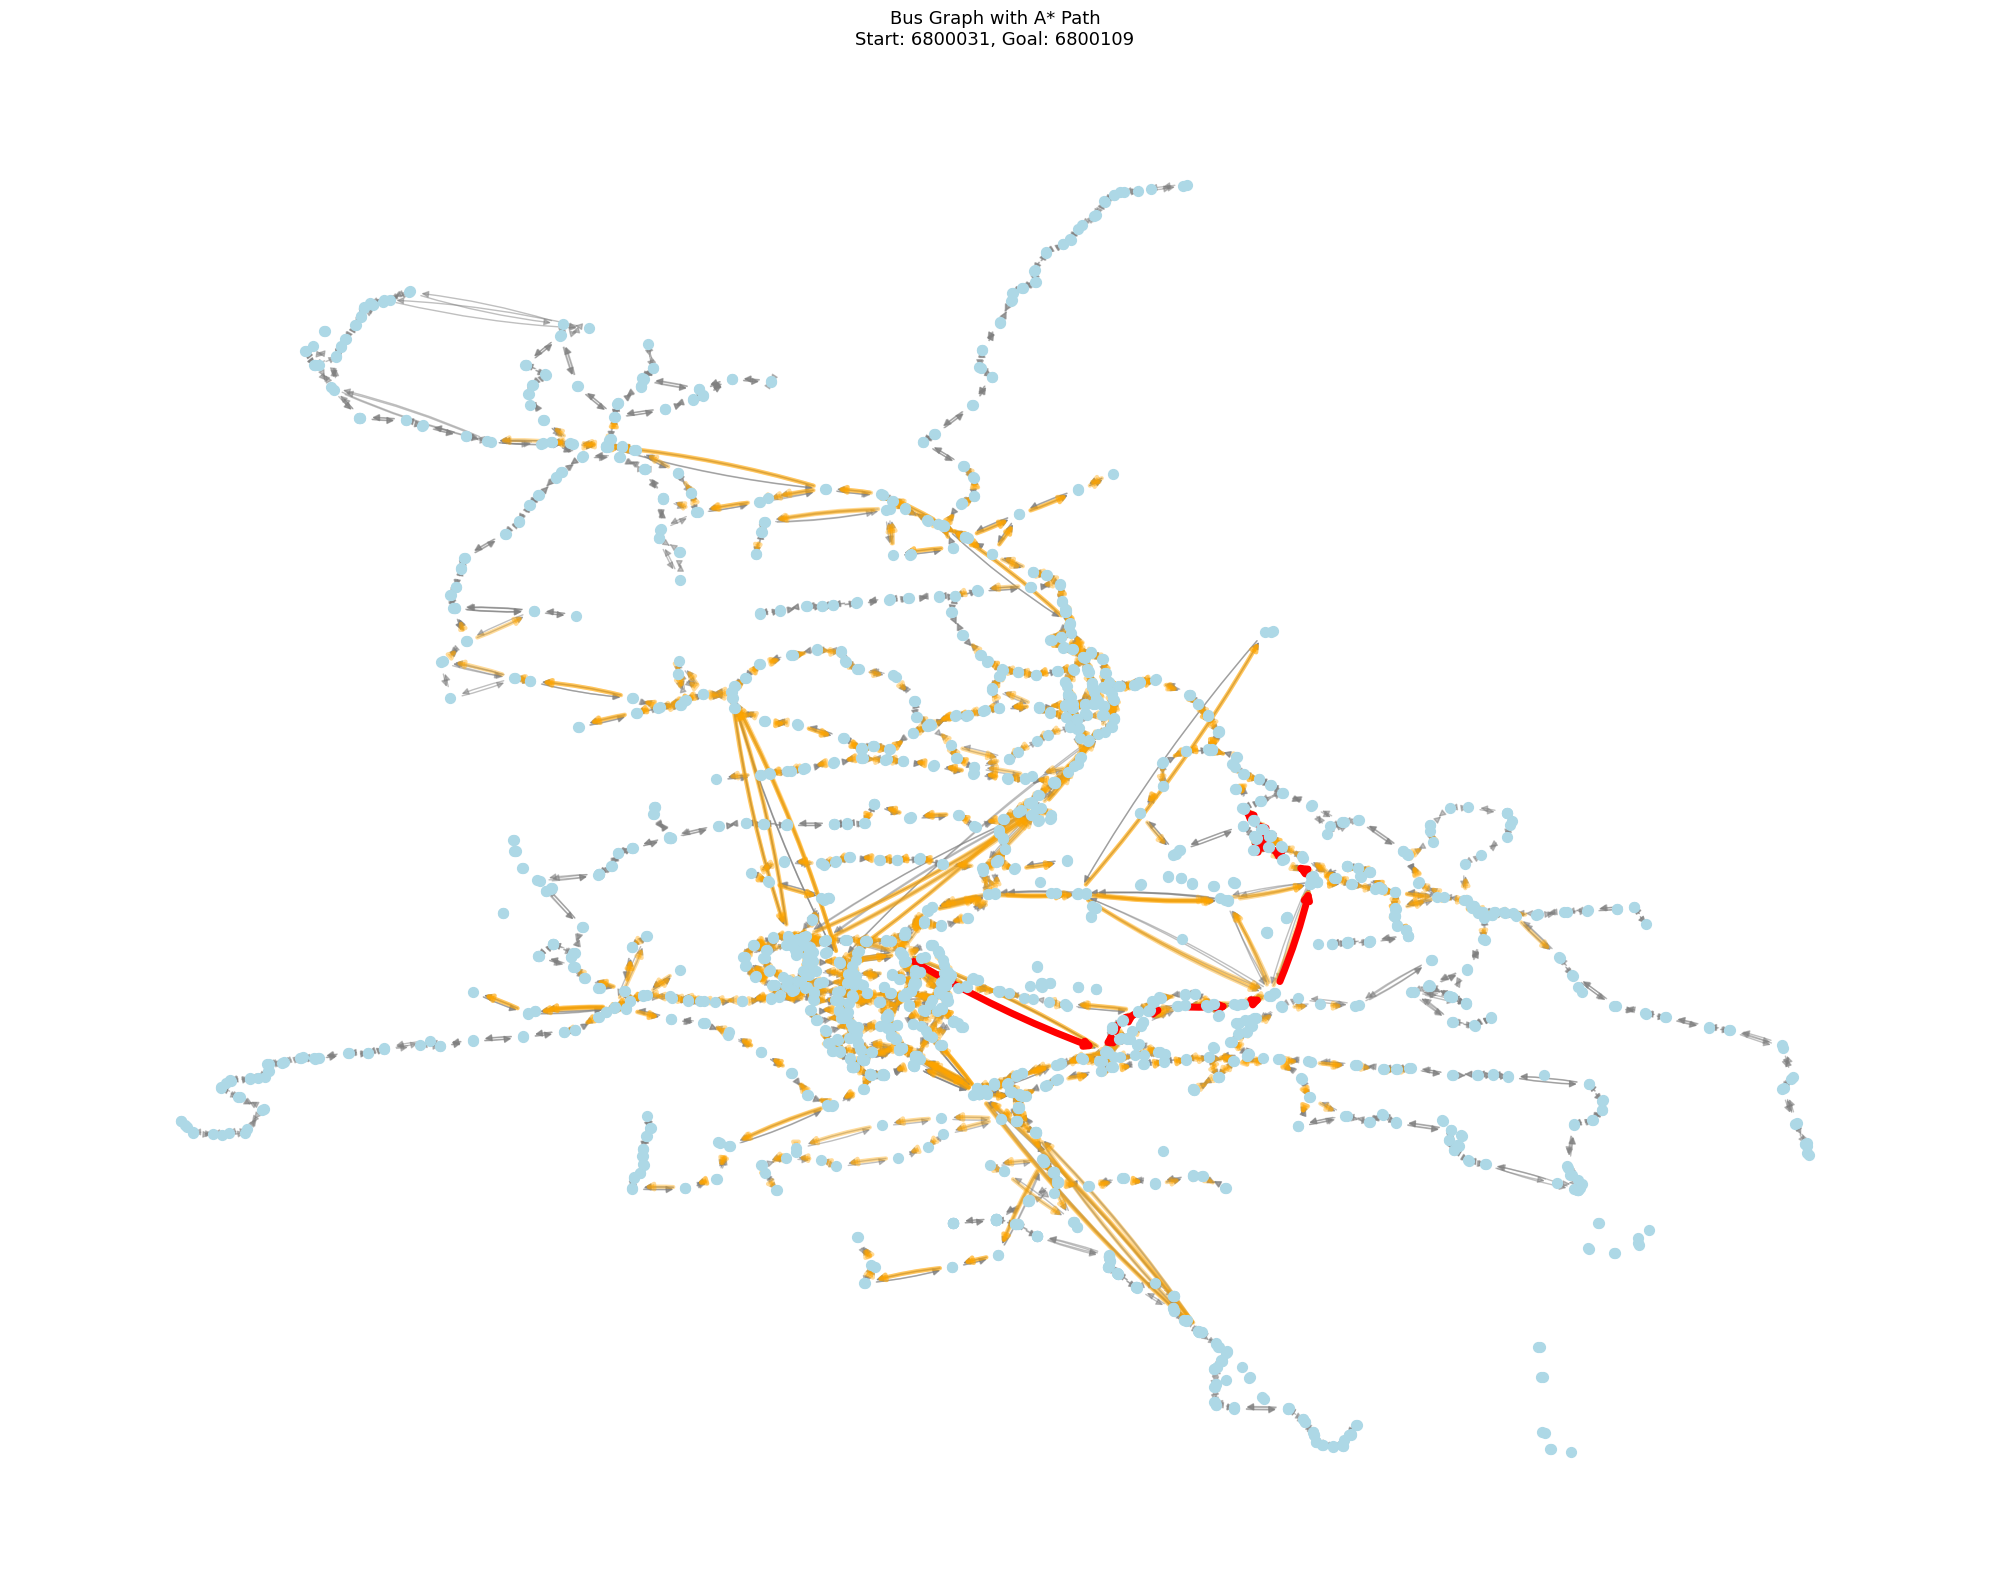

In [50]:
# 최단경로 시각화
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title="Bus Graph with A* Path"
)

In [ ]:
# 방향성 고려해서 수정하기